# ***Brain Tumor Classification***

## ***Import necessary libraries***

In [1]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from sklearn.metrics import classification_report
import keras.optimizers
from keras.applications import vgg16
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import cv2

## ***Define Directories and Constants***

In [2]:
# Define necessary constants
TEST_DIR = 'Testing'
TRAIN_DIR = 'Training'
IMG_SIZE = 224
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

## ***Creating and Saving the Training Dataset***

In [3]:
# Creating training dataset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR,category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          training_data.append([new_array, class_num])

    random.shuffle(training_data)

create_training_data()
#np.save('train_data.npy', training_data)
print(len(training_data))

print("train")
print()
X_train = np.array([i[0] for i in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = [i[1] for i in training_data]

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("Y_train.pickle","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()

  0%|          | 0/826 [00:00<?, ?it/s]

100%|██████████| 827/827 [00:04<00:00, 185.85it/s]


2870
train



In [4]:
X_train.shape

(2870, 224, 224, 3)

In [6]:
Y_train.shape

AttributeError: 'list' object has no attribute 'shape'

## ***Creating and Saving the Testing Dataset***

In [7]:
# Creating testing dataset
testing_data = []

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          testing_data.append([new_array, class_num])

    random.shuffle(testing_data)

create_testing_data()
#np.save('testing_data.npy', testing_data)
print(len(testing_data))

print("testing")
print()
X_test= np.array([i[0] for i in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_test = [i[1] for i in testing_data]

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("Y_test.pickle","wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()

100%|██████████| 74/74 [00:00<00:00, 84.02it/s]


394
testing



In [61]:
X_test.shape

(394, 224, 224, 3)

In [8]:
Y_test.shape

AttributeError: 'list' object has no attribute 'shape'

## ***Function-Show-images before training***

In [9]:
import matplotlib.pyplot as plt

# Function to display images
def show_images(images, labels, class_labels):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(class_labels[labels[i]])
        ax.axis('off')
    plt.show()

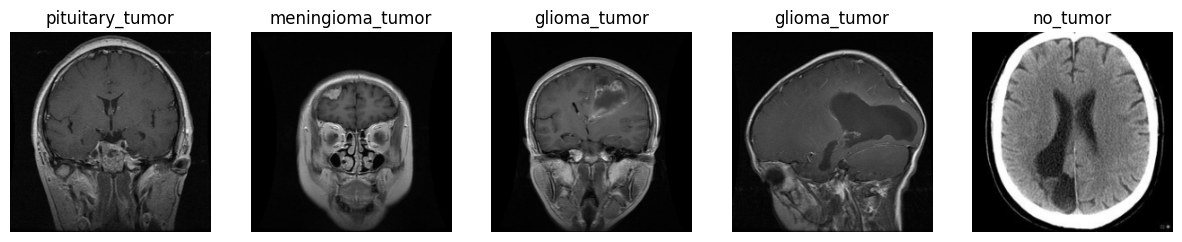

In [16]:
# Display a few images from the training dataset
num_images_to_display = 5
show_images(X_train[:num_images_to_display], Y_train[:num_images_to_display], CATEGORIES)

## ***TensorBoard and EarlyStopping Configuration***


In [19]:
tensorboard = TensorBoard(log_dir='./VGG16logs', histogram_freq=0,
                          write_graph=True, write_images=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

## ***Loading VGG16 Model with Custom Weights***

In [20]:
import os
from tensorflow.keras.applications import VGG16

# Define the path to the weights file
weights_path = './vgg16_weights_tf_dim_ordering_tf_kernels.h5'

# Check if the file exists
if not os.path.exists(weights_path):
    raise ValueError(f"Weights file not found at: {weights_path}")

# Load the VGG16 model with the specified weights
vgg16_model = VGG16(weights=weights_path)

# Display the summary of the model
vgg16_model.summary()

# Check the type of the model
print(type(vgg16_model))


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## ***constructing a neural network model using Keras***

In [21]:
from keras.models import Sequential
from keras.layers import Dense
# Dropping last layers
model = Sequential()
for layer in vgg16_model.layers[:-3]:
    model.add(layer)


for layer in model.layers:
    layer.trainable = True

# Adding last Dense Layer
model.add(Dense(4,activation = 'softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      


## ***Model-Compilation***

In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'],
              )

## ***Normalization***

In [23]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

## ***Training the Model***

In [25]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=12)

Epoch 1/12
90/90 [==============================] - 2030s 23s/step - loss: 1.3117 - accuracy: 0.3826
Epoch 2/12
90/90 [==============================] - 1960s 22s/step - loss: 0.9635 - accuracy: 0.5627
Epoch 3/12
90/90 [==============================] - 1589s 18s/step - loss: 0.7977 - accuracy: 0.6491
Epoch 4/12
90/90 [==============================] - 916s 10s/step - loss: 0.6857 - accuracy: 0.7105
Epoch 5/12
90/90 [==============================] - 965s 11s/step - loss: 0.5730 - accuracy: 0.7578
Epoch 6/12
90/90 [==============================] - 1316s 15s/step - loss: 0.5256 - accuracy: 0.7868
Epoch 7/12
90/90 [==============================] - 1902s 21s/step - loss: 0.4863 - accuracy: 0.8080
Epoch 8/12
90/90 [==============================] - 1845s 21s/step - loss: 0.4242 - accuracy: 0.8376
Epoch 9/12
90/90 [==============================] - 1830s 20s/step - loss: 0.3908 - accuracy: 0.8488
Epoch 10/12
90/90 [==============================] - 1832s 20s/step - loss: 0.2877 - accuracy

# ***Evaluate the Model***

In [26]:
# Evaluate the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

13/13 [==============================] - 79s 6s/step - loss: 2.5490 - accuracy: 0.6168
Test loss: 2.549043655395508
Test accuracy: 0.6167512536048889


## ***Model-Saving***

In [28]:
model.save("model.h5") # replace model.h5 in "Runner"


## ***Model-Evaluation***

In [29]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_bool))

7/7 [==============================] - 78s 11s/step
              precision    recall  f1-score   support

           0       1.00      0.10      0.18       100
           1       0.64      0.74      0.69       115
           2       0.53      0.97      0.69       105
           3       0.77      0.62      0.69        74

    accuracy                           0.62       394
   macro avg       0.74      0.61      0.56       394
weighted avg       0.73      0.62      0.56       394



## ***Function-Images-Predictions***

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_with_predictions(images, predictions, class_labels, true_labels=None):
    num_images = len(images)
    cols = 5
    rows = np.ceil(num_images / cols).astype(int)

    plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])  # Assuming images are in RGB format
        predicted_class_index = np.argmax(predictions[i])
        predicted_class = class_labels[predicted_class_index]
        
        if true_labels is not None:
            true_class_index = true_labels[i]
            true_class = class_labels[true_class_index]
            title = f"P: {predicted_class}\nT: {true_class}"
        else:
            title = f"P: {predicted_class}"

        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## ***Function-Load-Test-Data***

In [32]:
import pickle
import numpy as np

# Function to load test data
def load_your_test_data():
    # Load the test data
    with open("X_test.pickle", "rb") as pickle_in:
        X_test = pickle.load(pickle_in)
        
    with open("Y_test.pickle", "rb") as pickle_in:
        Y_test = pickle.load(pickle_in)
        
    return np.array(X_test), np.array(Y_test)

# Load the test data
X_test, Y_test = load_your_test_data()

# Ensure the data is normalized (if it was normalized during training)
X_test = X_test / 255.0

# Verify the shape of the loaded data
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_test shape: (394, 224, 224, 3)
Y_test shape: (394,)


In [34]:
test_data, test_labels = load_your_test_data()

In [35]:
predictions = model.predict(test_data)

13/13 [==============================] - 82s 6s/step


In [45]:
print("Predictions type:", type(predictions))
print("Predictions shape:", np.shape(predictions))
print("Predictions sample:", predictions[:10])


Predictions type: <class 'numpy.ndarray'>
Predictions shape: (394, 4)
Predictions sample: [[0.0000000e+00 1.0000000e+00 1.6386973e-20 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 2.1341710e-25 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]


In [37]:
class_labels = CATEGORIES 

## ***Show-Images-With-Predictions***

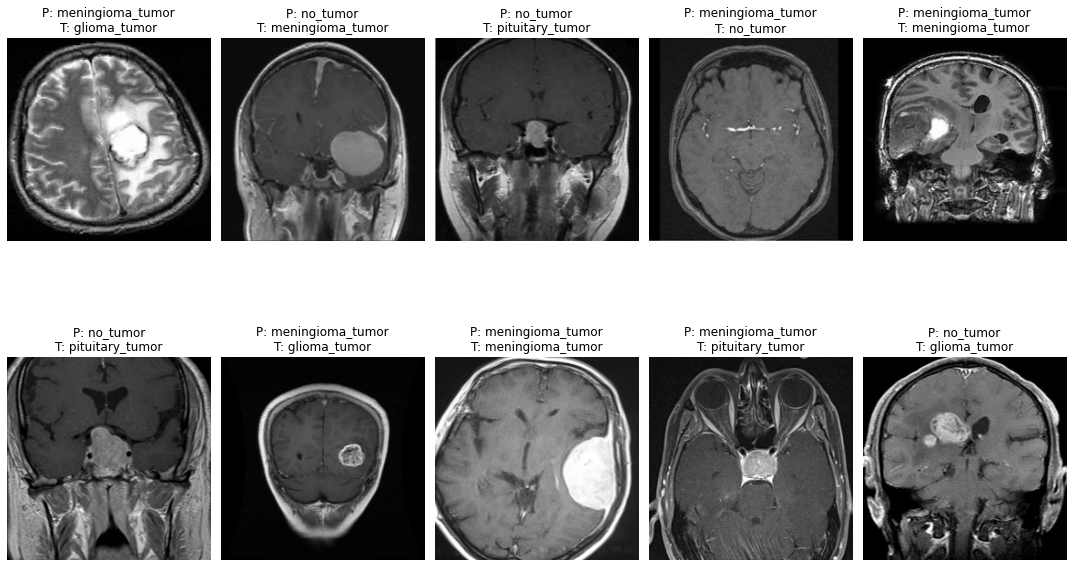

In [53]:

# Example usage:
# Assuming test_data is your test dataset and predictions are the corresponding model predictions
class_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Example: show images with true labels if you have them
show_images_with_predictions(test_data[:10], predictions[:10], class_labels, true_labels=Y_test[:10])

# Example: show images without true labels
# show_images_with_predictions(test_data[:10], predictions[:10], class_labels)
